In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.utils import resample

In [2]:
# Merge our DFT result data with the Kraken ML data for the ligands.
dft_df = pd.read_csv("dft_data/lowest_E_isomers_lambda_max_data.csv")
kraken_df = pd.read_csv("kraken_data/ml_8_210.csv")

merged_df = pd.merge(dft_df, kraken_df, on="molecule_id")



# Here we are limiting ourselves to ONLY cases where there is an agostic interaction in the fourth site.
merged_df = merged_df[merged_df["Pd_X_elem"]=="H"]



# Effectively, I think of this as a left joining kraken_df on dft_df
merged_df.head()

,molecule_id,input_filename,lambda_max,shift,Pd_X_elem,Pd-X_len,smiles,dipolemoment_max,pyr_P_max,pyr_alpha_max,...,vbur_qvbur_max_boltzmann_average,vbur_qvbur_min_boltzmann_average,vbur_qvtot_max_boltzmann_average,vbur_qvtot_min_boltzmann_average,vbur_ratio_vbur_vtot_boltzmann_average,vbur_vbur_boltzmann_average,vbur_vtot_boltzmann_average,vmin_r_boltzmann_average,vmin_vmin_boltzmann_average,volume_boltzmann_average
1,12,12_PdMeCl_single_pt_quick,421.5,26.1,H,2.59931,CC(C)(C)CP(C(C)(C)C)C(C)(C)C,0.819760,0.883014,28.707630,...,21.402498,14.062596,89.652150,54.039700,0.271465,74.782196,271.61676,1.767097,-0.064135,345.01490
2,136822,136822_PdMeCl_rotamer_Ar_iPr_over_single_pt_quick,359.8,-35.6,H,1.90055,CC(C)c1cccc(C(C)C)c1P(C)C,1.028708,0.850064,25.540834,...,24.599785,11.072448,137.355500,30.649036,0.238911,68.690790,270.22723,1.772235,-0.050981,328.80890
3,146504,146504_PdMeCl_rotamer_SiMe_over_single_pt_quick,392.4,-3.0,H,2.28855,CC(C)(C)P(C[Si](C)(C)C)C[Si](C)(C)C,0.855991,0.922159,22.777857,...,22.936695,14.237702,96.894844,60.429905,0.247438,81.479940,327.67990,1.772402,-0.060953,408.25940
4,149973,149973_PdMeCl_tweak_Hept_over_single_pt_quick,406.1,10.7,H,2.29324,CC(C)C(C(C)C)P([Si](C)(C)C)[Si](C)(C)C,1.221320,0.918042,30.071001,...,23.145735,12.793634,124.574684,62.425888,0.219198,70.792600,343.27954,1.827484,-0.050907,425.43533
5,149979,149979_PdMeCl_single_pt,405.5,10.1,H,2.49769,CC(C)N(C(C)C)P([Si](C)(C)C)[Si](C)(C)C,1.332590,0.915157,27.480660,...,24.916720,12.449173,112.976020,66.201920,0.213264,71.054310,341.42294,1.838351,-0.049263,421.33942


In [3]:
# Full features:
features_df = merged_df.iloc[:,7:]
X = features_df.values
target = merged_df.columns[2]
y = merged_df[target].values
print(X.shape)
print(y.shape)

(76, 190)
(76,)


In [4]:
from sklearn.model_selection import LeaveOneOut

def loocv(X, y, model, verbose=False):
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    
    y_preds = []
    for i, (train_indices, test_index) in enumerate(loo.split(X)):
        X_train, y_train = X[train_indices], y[train_indices]
        X_test, y_test = X[test_index], y[test_index]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_preds.append(y_pred[0])
    return y_preds

In [5]:
seen_features = set()
feature_order = []
alpha_values = []
loocv_mses = []
r2s = []

for num_feats in range(1, 3):
    model = Ridge(tol=0.0001, max_iter = 1000000)
    search_space = { "alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100] }
    gs_ridge = GridSearchCV(
        estimator=model,
        param_grid=search_space,
        scoring=["r2"],
        refit="r2",
        cv=5
    )
    
    selector = SequentialFeatureSelector(gs_ridge, n_features_to_select=num_feats, scoring='r2')
    selector.fit(X, y)
    selected_features = list(features_df.columns[selector.get_support()])

    # find the added feature
    for feature in selected_features:
        if feature not in seen_features:
            seen_features.add(feature)
            feature_order.append(feature)
            break

    # use only the num_feats features here
    features = merged_df[feature_order]
    X_num_feats = features.values
    target = "lambda_max"

    # get alpha
    gs_ridge.fit(X_num_feats, y)
    best_alpha = gs_ridge.best_estimator_.get_params()["alpha"]
    alpha_values.append(best_alpha)

    model_alpha = Ridge(alpha=best_alpha, tol=0.0001, max_iter = 1000000)

    # get LOOCV MSE
    y_preds = loocv(X_num_feats, y, model_alpha)
    squared_errors = []
    for i in range(len(y_preds)):
        squared_errors.append(round((y_preds[i] - y[i]) ** 2, 1))
    loocv_mses.append(round((sum(squared_errors) / len(squared_errors)), 1))

    # Get R2
    model_alpha.fit(X_num_feats, y)
    r2s.append(model_alpha.score(X_num_feats, y))
    
    print(f"num_feats={num_feats} complete.")
    
print(feature_order, alpha_values, loocv_mses, r2s)

num_feats=1 complete.
num_feats=2 complete.
['vbur_qvbur_max_min', 'vbur_vbur_vburminconf'] [10, 10] [297.5, 296.8] [0.2668052558690489, 0.28814231784246735]


In [6]:
# Also, how much better is out model than a 1-parameter regression with Pd-X length?
# for what that model would lack in flexibility it may just fare well due to not overfitting...
# basically, does the Kraken ML data really add anything or not, is it actually learning from that stuff
from sklearn.linear_model import LinearRegression
import numpy as np

linear_agostic = LinearRegression()
PdX_only_df = merged_df.loc[:, ["lambda_max", "Pd-X_len"]].dropna(axis=0)
X_PdX = PdX_only_df["Pd-X_len"].to_numpy().reshape(-1, 1)
y_PdX = PdX_only_df["lambda_max"].to_numpy()
linear_agostic.fit(X_PdX, y_PdX)

print(f"Linear, agostic R2: {linear_agostic.score(X_PdX, y_PdX)}")

Linear, agostic R2: 0.520671448372089


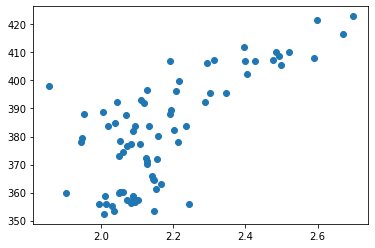

In [7]:
plt.scatter(X_PdX, y_PdX)
plt.show()

In [8]:
y_preds = loocv(X_PdX, y_PdX, LinearRegression())
# print(y_preds)

In [9]:
def calc_squared_errors(y_preds, y):
    squared_errors = []
    for i in range(len(y_preds)):
        squared_errors.append(round((y_preds[i] - y[i]) ** 2, 1))
    return squared_errors

def calc_mse(y_preds, y):
    squared_errors = calc_squared_errors(y_preds, y)
    return round((sum(squared_errors) / len(squared_errors)), 1)


print(f"LOOCV MSE: {calc_mse(y_preds, y)}")

LOOCV MSE: 194.0
